# Image To Image Translation - Self Case Study 2

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, ReLU, Concatenate, Activation,ZeroPadding2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

## Loading Data

In [ ]:
image_data = np.load('/kaggle/input/i2i-data/image_data.npz')

In [ ]:
train_sat_images = image_data['train_sat_images']
train_map_images = image_data['train_map_images']

## Modeling

### Basic Model

For basic model, we'll be implementing cGAN (without L1 regularization).
<br>
Our model consists of 2 parts:
- Generator
- Discriminator

#### Defining Generator

In [ ]:
#https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/
#https://stackoverflow.com/questions/69085333/input-has-undefined-rank-tensorshapenone-error-in-building-resnet
# defining generator
def encoder_block(layer_in, filters, is_batch_norm = True, name = 'encoder_block'):
    X = Conv2D(filters, kernel_size= (4,4), strides= (2,2), padding= 'same', kernel_initializer= RandomNormal(stddev= 0.02), name = name+'_conv')(layer_in)
    if is_batch_norm:
        X = BatchNormalization(name = name+'_bn')(X, training = True)
    X = LeakyReLU(alpha = 0.2, name = name +'_activation')(X)
    return X

In [ ]:
def decoder_block(layer_in, skip_conn_layer, filters, is_dropout = True, name = 'decoder_block'):
    X = Conv2DTranspose(filters, kernel_size= (4,4), strides= (2,2), padding= 'same', kernel_initializer= RandomNormal(stddev= 0.02), name = name+'_convT')(layer_in)
    X = BatchNormalization(name = name+'_bn')(X, training = True)
    if is_dropout:
        X = Dropout(0.5, name = name+'_dropout')(X, training = True)
    X = Concatenate(name = name +'_concat')([X, skip_conn_layer])
    X = Activation('relu', name = name+'_activation')(X)
    return X

In [ ]:
def define_generator(input_shape):
    input = Input(shape = input_shape, name = 'generator_input')

    e1 = encoder_block(input, filters = 64, is_batch_norm= False, name= 'encoder_block_1')
    e2 = encoder_block(e1, filters = 128, name = 'encoder_block_2')
    e3 = encoder_block(e2, filters = 256, name = 'encoder_block_3')
    e4 = encoder_block(e3, filters = 512, name = 'encoder_block_4')
    e5 = encoder_block(e4, filters = 512, name = 'encoder_block_5')
    e6 = encoder_block(e5, filters = 512, name = 'encoder_block_6')
    e7 = encoder_block(e6, filters = 512, name = 'encoder_block_7')

    # bottleneck 
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer= RandomNormal(stddev=0.02), name = 'bottleneck_conv')(e7)
    b = Activation('relu', name= 'bottleneck_activation')(b)

    # decoder model
    d1 = decoder_block(b, skip_conn_layer= e7, filters= 512, name = 'decoder_block_1')
    d2 = decoder_block(d1, skip_conn_layer= e6, filters= 512, name = 'decoder_block_2')
    d3 = decoder_block(d2, skip_conn_layer= e5, filters= 512, name = 'decoder_block_3')
    d4 = decoder_block(d3, skip_conn_layer= e4, filters= 512, is_dropout=False, name = 'decoder_block_4')
    d5 = decoder_block(d4, skip_conn_layer= e3, filters= 256, is_dropout=False, name = 'decoder_block_5')
    d6 = decoder_block(d5, skip_conn_layer= e2, filters= 128, is_dropout= False, name = 'decoder_block_6')
    d7 = decoder_block(d6, skip_conn_layer = e1, filters=64, is_dropout= False, name = 'decoder_block_7')
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(stddev=0.02), name = 'output_conv')(d7)
    out_image = Activation('tanh', name= 'output_activation')(g)
    # define model
    model = Model(input, out_image, name ='Generator')
    return model

Generator structure is as follows:

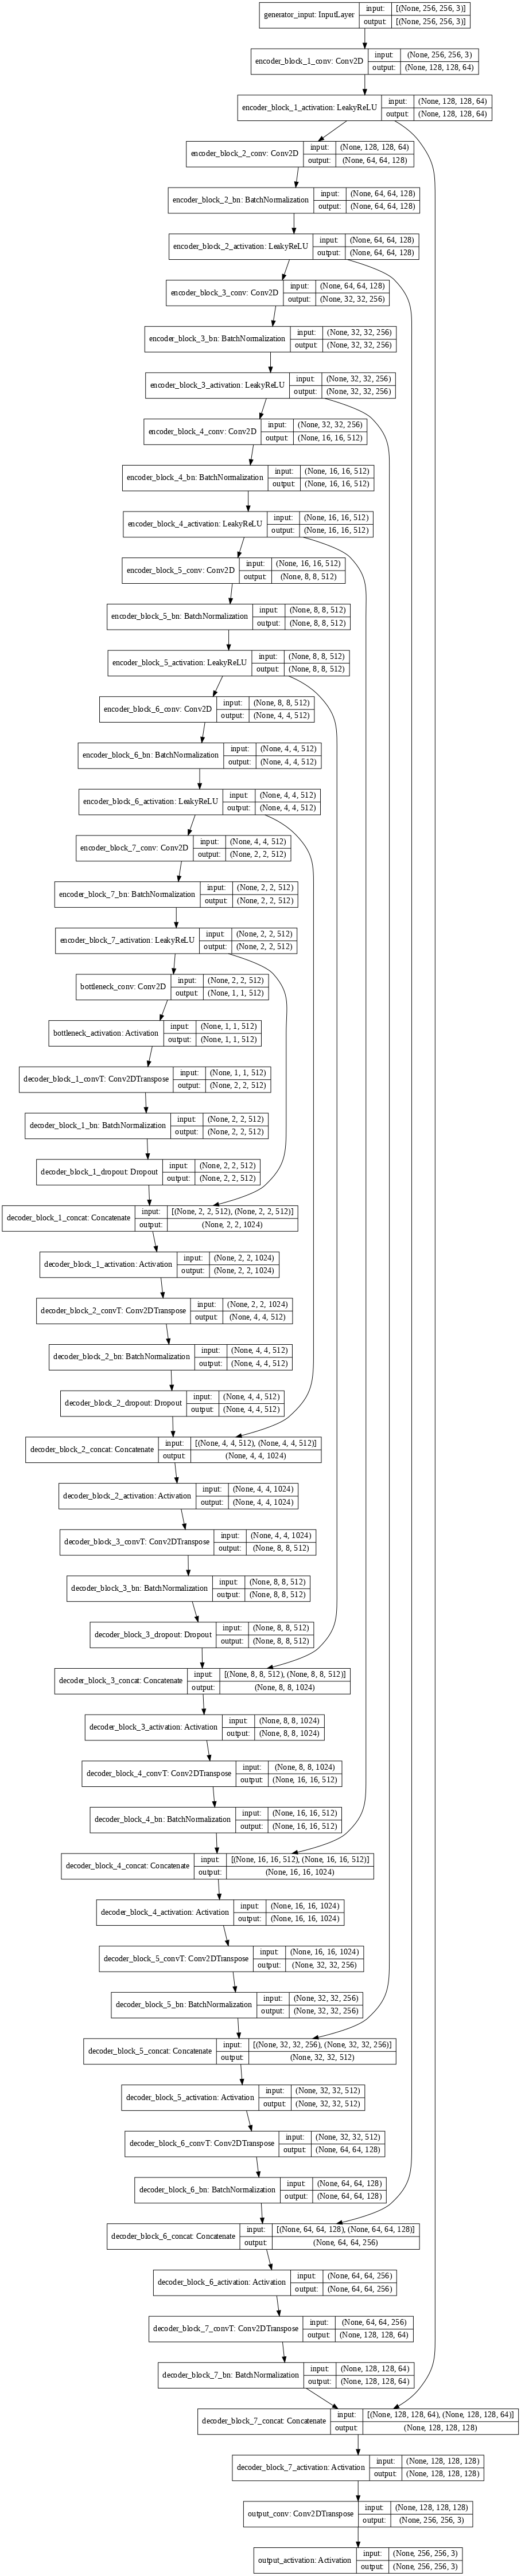

#### Defining Discriminator

In [ ]:
def discriminator_block(layer_in, filters,stride =2, padding='same', is_batch_norm = True, name = 'discriminator_block'):
    X = Conv2D(filters, kernel_size= (4,4), strides= stride, padding= padding, kernel_initializer= RandomNormal(stddev= 0.02), name = name+'_conv' )(layer_in)
    if is_batch_norm:
        X = BatchNormalization(name = name+'_bn')(X)
    X = LeakyReLU(alpha = 0.2, name = name+'_leakyrelu')(X)
    return X

In [ ]:
#https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_discriminator
def define_discriminator(input_shape):
    '''This function takes in shape of image as input and return discriminator model '''
    in_source_image = Input(shape= input_shape, name = 'discriminator_source_image_input')
    in_target_image = Input(shape= input_shape, name = 'discriminator_target_image_input')
    discriminator_input = Concatenate()([in_source_image, in_target_image])

    d1 = discriminator_block(discriminator_input, filters= 64, is_batch_norm= False, name = 'discriminator_block_1')
    d2 = discriminator_block(d1, filters= 128, name = 'discriminator_block_2')
    d3 = discriminator_block(d2, filters = 256, name = 'discriminator_block_3')

    pad1 = ZeroPadding2D(name = 'padding_1')(d3)
    
    d4 = discriminator_block(pad1, filters= 512,stride =1,padding ='valid', name = 'discriminator_block_4')

    pad2 = ZeroPadding2D(name = 'padding_2')(d4)
    
    output_conv = Conv2D(filters= 1, kernel_size= (4,4), kernel_initializer= RandomNormal(stddev= 0.02), name='output_conv')(pad2)
    output = Activation('sigmoid')(output_conv)
    model = Model([in_source_image, in_target_image], output, name ='Discriminator')

    model.compile(loss ='binary_crossentropy', optimizer= Adam(learning_rate= 0.0002, beta_1= 0.5), loss_weights= [0.5])

    return model

Discriminator structure is as follows: 

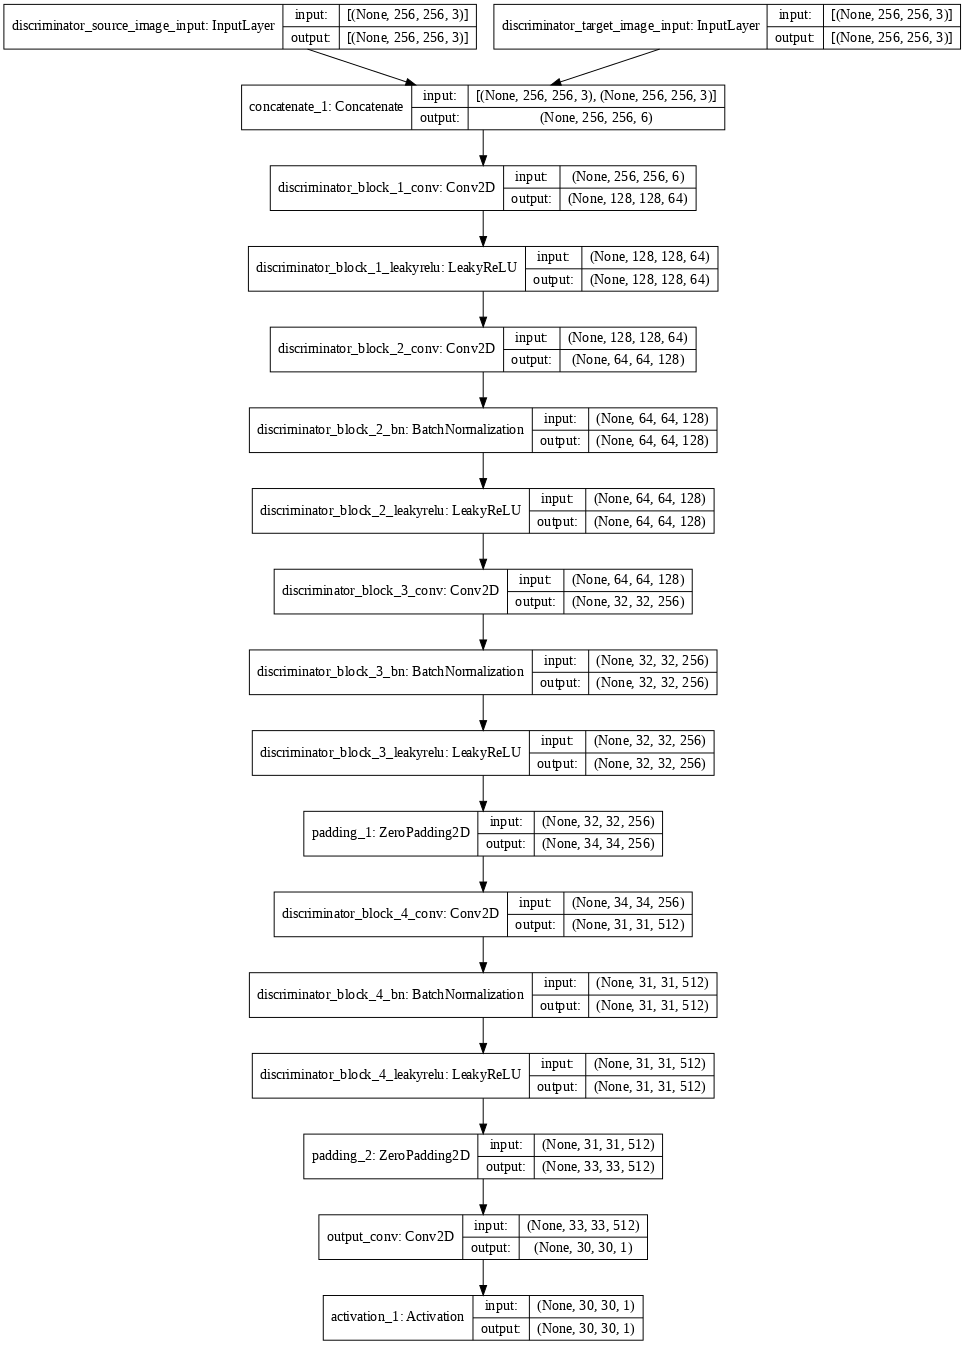

#### Defining CGAN

In [ ]:
def define_cgan(generator, discriminator, input_shape):
    for layer in discriminator.layers:
        layer.trainable = False
    
    input_source = Input(shape=input_shape, name = 'cgan_input')

    gen_out = generator(input_source)

    dis_out = discriminator([input_source, gen_out])

    model = Model(input_source, [dis_out, gen_out], name ='CGAN')

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

#### Generating samples for training

In [ ]:
#https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/
def generate_real_samples(sat_images, map_images, batch_size, patch_size):
    sample = np.random.randint(0,sat_images.shape[0],batch_size)
    sample_sat_image = sat_images[sample]
    sample_map_image = map_images[sample]

    y = np.ones((batch_size, patch_size, patch_size, 1))
    y = np.where(y == 1, 0.9, 1)
    return [sample_sat_image, sample_map_image] , y

In [ ]:
def generate_fake_samples(sample, generator, patch_size):
    X = generator.predict(sample)
    y = np.zeros((len(X), patch_size, patch_size, 1))
    return X, y

#### Training

In [ ]:
#https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/
# generate samples and save as a plot and save the model
def summarize_performance(epoch, generator, sat_images, map_images, n_samples=3):
    # select a sample of input images
    [X_sat_image_real, X_map_image_real], _ = generate_real_samples(sat_images, map_images, n_samples, 1)
    
    # generate a batch of fake samples
    map_image_generated, _ = generate_fake_samples(X_sat_image_real, generator, 1)

    # scale all pixels from [-1,1] to [0,1]
    X_sat_image_real = (X_sat_image_real + 1) / 2.0
    X_map_image_real = (X_map_image_real + 1) / 2.0
    map_image_generated = (map_image_generated + 1) / 2.0

    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_sat_image_real[i])
    
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(map_image_generated[i])
    
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_map_image_real[i])
    
    # save plot to file
    filename1 = 'plot_{}.png'.format(epoch)
    plt.savefig(filename1)
    plt.close()
    
    # save the generator model
    filename2 = 'model_{}.h5'.format(epoch)
    generator.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
def train(discriminator, generator, cgan_model, sat_images, map_images, epochs = 200, batch_size = 1):
    patch_size = discriminator.output_shape[1]
    batch_per_epoch = int(len(sat_images)/ batch_size)
    steps = batch_per_epoch*epochs
    
    for epoch in range(epochs):
        print('Epoch: {}/{}'.format(epoch+1, epochs))
        for step in range(batch_per_epoch):
            [X_sat_real, X_map_real],  y_real = generate_real_samples(sat_images, map_images, batch_size, patch_size)
            X_map_fake, y_fake = generate_fake_samples(X_sat_real, generator, patch_size)

            d_loss1 = discriminator.train_on_batch([X_sat_real, X_map_real], y_real)
            d_loss2 = discriminator.train_on_batch([X_sat_real, X_map_fake], y_fake)
            
            g_loss, _, _ = cgan_model.train_on_batch(X_sat_real, [y_real, X_map_real])
            
            if((step+1) % 10 == 0):
                print('.',end = '')
            if((step+1)%100 == 0):
                print(' Batch {}/{} d_loss1:{} d_loss2 :{} g_loss :{}'.format(step+1,batch_per_epoch, d_loss1, d_loss2, g_loss))
        
        # summarize model performance every 15 epochs
        if ((epoch + 1) % 20 == 0):
            summarize_performance(epoch+1, generator, sat_images, map_images)

In [ ]:
image_shape = train_sat_images.shape[1:]

In [ ]:
discriminator = define_discriminator(image_shape)
generator = define_generator(image_shape)
cgan = define_cgan(generator, discriminator, image_shape)

train(discriminator, generator, cgan, train_sat_images, train_map_images)

The results are as follows:

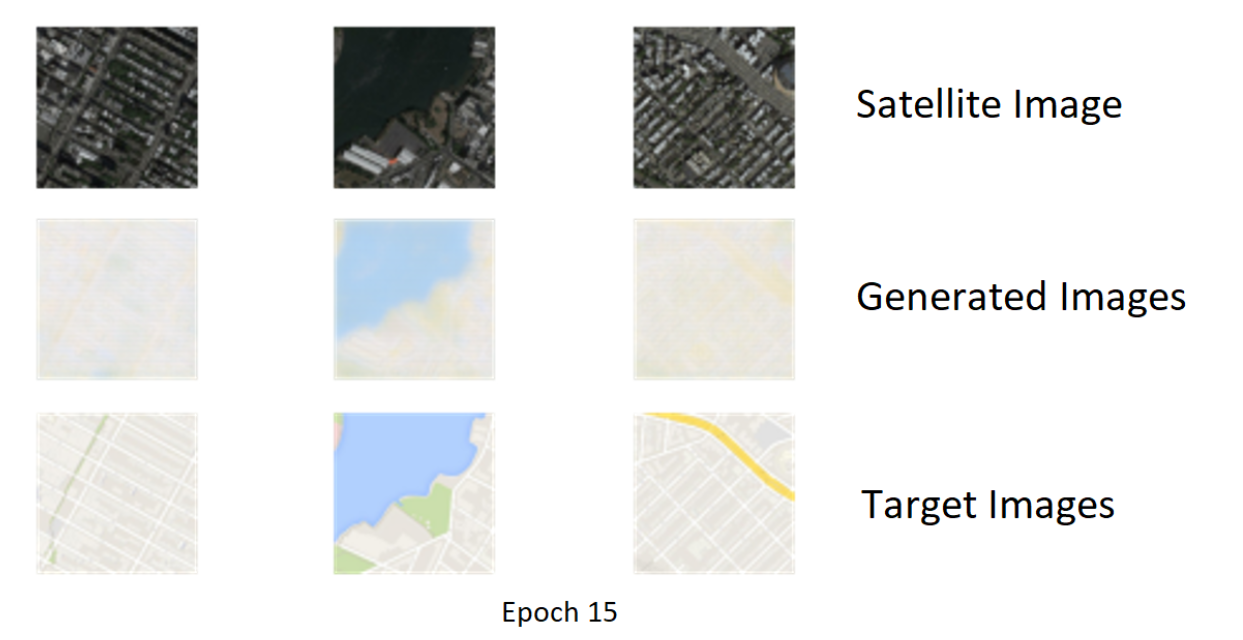

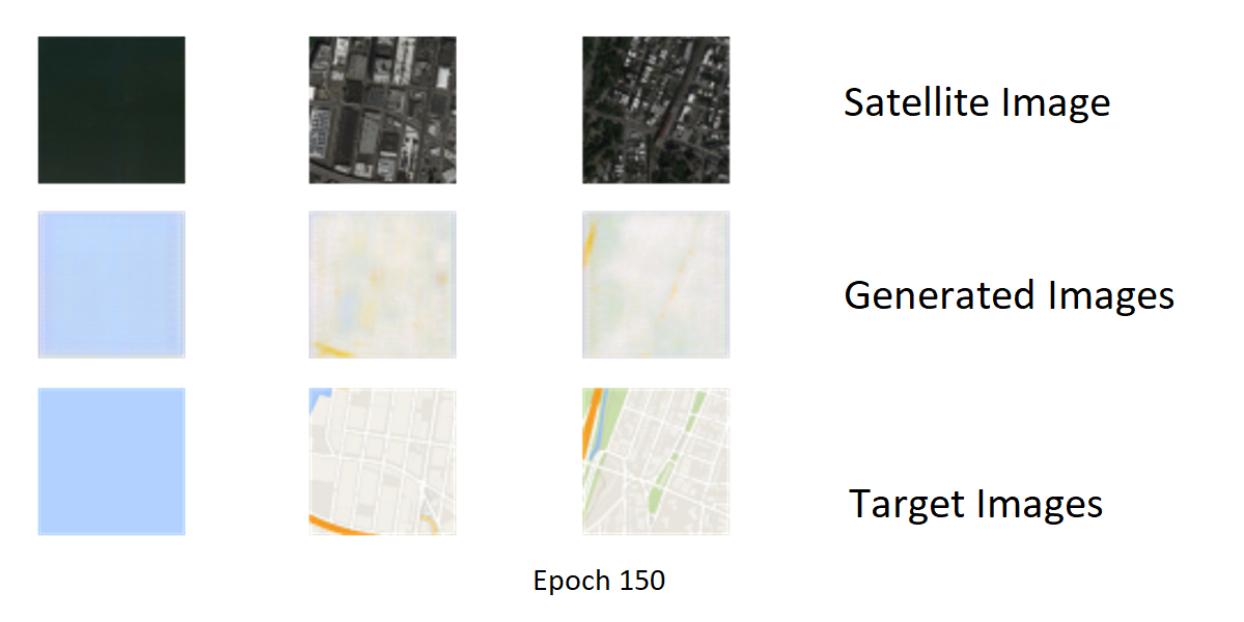

Even after 150 epochs of training, the model is producing blurry outputs.

Let's look into cgan with L1 regularization.

In [ ]:
def define_cgan_with_l1(generator, discriminator, input_shape):
    for layer in discriminator.layers:
        layer.trainable = False
    
    input_source = Input(shape=input_shape, name = 'cgan_input')

    gen_out = generator(input_source)

    dis_out = discriminator([input_source, gen_out])

    model = Model(input_source, [dis_out, gen_out], name ='CGAN')

    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[1,100])
    return model

In [ ]:
discriminator = define_discriminator(image_shape)
generator = define_generator(image_shape)
cgan = define_cgan_with_l1(generator, discriminator, image_shape)

train(discriminator, generator, cgan, train_sat_images, train_map_images)

Output are as follows:

![image.png](attachment:image.png)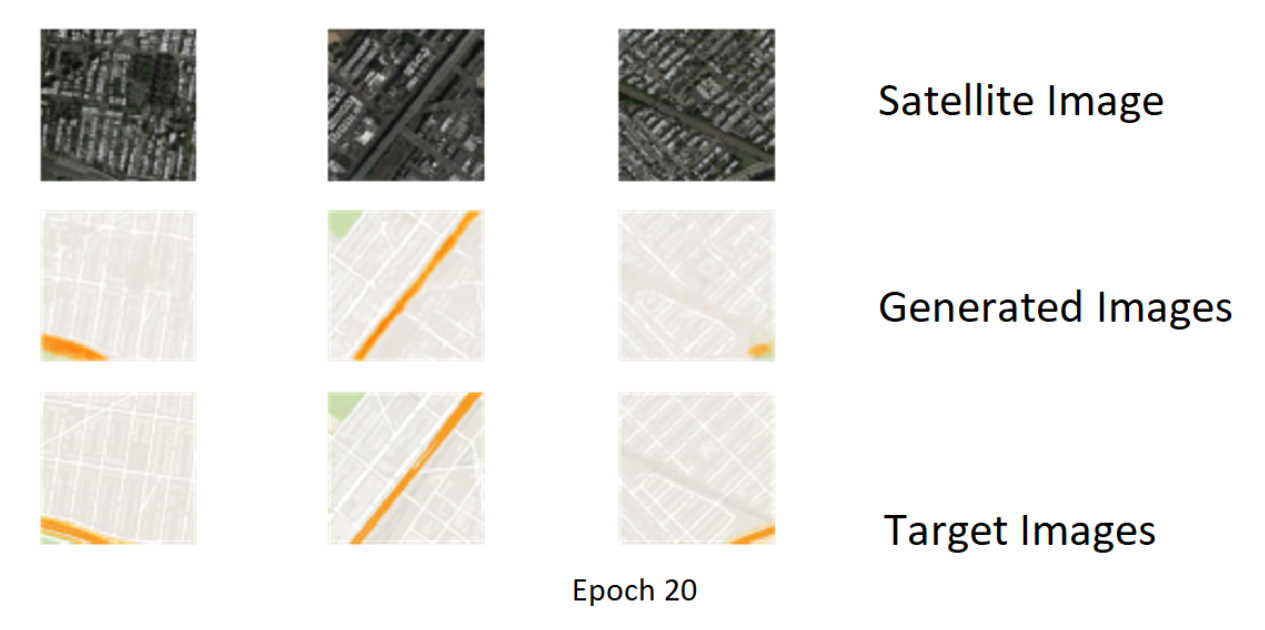

Observation:
- cGAN with L1 reg. - Epoch 20 result is much better than cGAN Epoch 150. Though Image is a bit wavey. Let's see how it unfolds as we train it more.

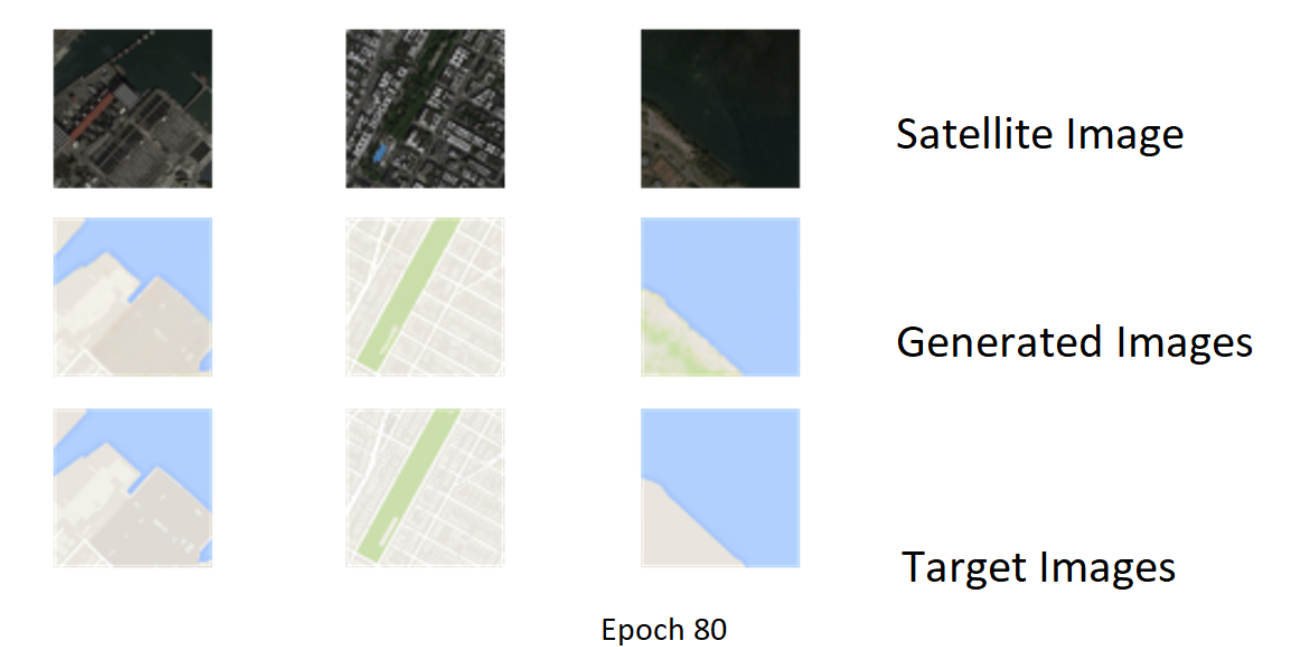

Observation:
- Image quailty is getting better.

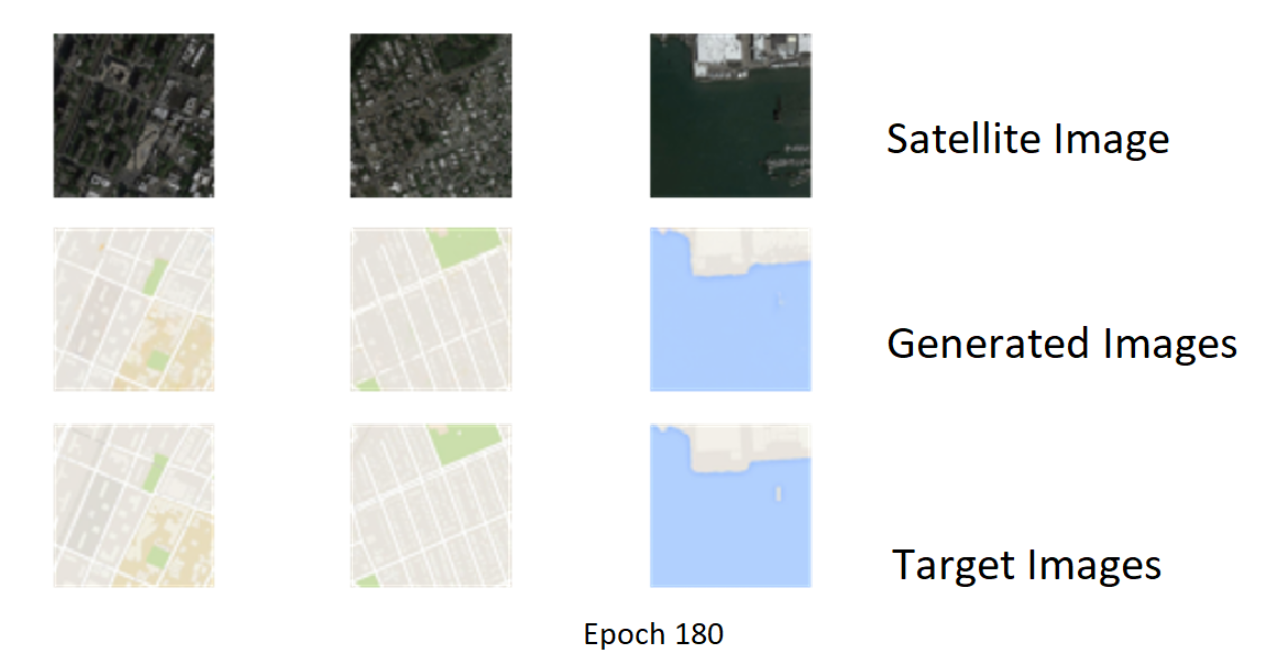

Observation:
- The generated images are nearly indistinguisable from the given aerial map images